In [67]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [68]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=e8c846f349b4ee6fc93c5ee12d42ecf151215fcb3c48f5507736d01d0614d724
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [69]:
FOLDS = 5
ESTIMATORS = 100
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [70]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [71]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             174 non-null    object 
 1   age             174 non-null    uint8  
 2   sex             174 non-null    object 
 3   smoking         174 non-null    object 
 4   week_1          174 non-null    int16  
 5   fvc_1           174 non-null    uint16 
 6   percent_1       174 non-null    float32
 7   fvc_last_1      174 non-null    uint16 
 8   fvc_last_2      174 non-null    uint16 
 9   fvc_last_3      174 non-null    uint16 
 10  week_last_1     174 non-null    int16  
 11  week_last_2     174 non-null    int16  
 12  week_last_3     174 non-null    int16  
 13  fvc_last_1_min  174 non-null    float32
 14  fvc_last_1_p50  174 non-null    float32
 15  fvc_last_1_p75  174 non-null    float32
 16  fvc_last_1_p90  174 non-null    float32
 17  fvc_last_1_p95  174 non-null    flo

In [72]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,877.997009,1005.925293,1028.511841,1054.165039,1059.198364,1092.614380,1105.930664,909.957153,1042.607422,1065.976685,1092.555908,1097.809082,1132.441528,1146.246216,882.640808,1011.476562,1034.188599,1059.873657,1065.067261,1098.717773,1112.120483
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,853.789856,1058.308838,1100.685913,1125.299316,1133.533203,1157.427246,1187.557129,884.876465,1096.842529,1140.813965,1166.294922,1174.834229,1199.594971,1230.818481,858.190796,1064.024414,1106.756592,1131.498169,1139.783936,1163.813354,1194.154907
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,850.927429,1078.974365,1160.992554,1186.172607,1195.204346,1222.503052,1223.925049,881.847107,1118.256348,1203.285645,1229.382812,1238.741821,1267.041748,1268.510620,855.303833,1084.852173,1167.382812,1192.773682,1201.854248,1229.338013,1230.764893
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,968.022400,1049.711548,1093.669556,1108.703979,1113.026855,1156.249268,1157.122192,1003.283630,1088.032349,1133.577026,1149.169678,1153.630249,1198.420410,1199.315796,973.224182,1055.562134,1099.799805,1114.923706,1119.292358,1162.752686,1163.627808
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,771.858398,896.745789,938.207275,963.104797,969.950500,981.271423,985.917175,800.051575,929.550110,972.487854,998.351257,1005.418823,1017.134583,1021.942017,775.840393,901.703552,943.329773,968.423889,975.309265,986.663391,991.320007


In [73]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}
col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}


In [74]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

27 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'percent_1', 'sex', 'smoking', 'week_1']


In [75]:
x_train = train[FEATURES]

In [76]:
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [0.01, 0.05, 0.1],
        'model__min_child_samples': [20, 40, 80],
        'model__colsample_bytree': [0.01, 0.05, 0.1]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM
    best params={'model__colsample_bytree': 0.1, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
    best score=-705.040, std=33.654
    
LGBM
    best params={'model__colsample_bytree': 0.1, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
    best score=-731.657, std=48.535
    
LGBM
    best params={'model__colsample_bytree': 0.1, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
    best score=-715.262, std=61.072
    


In [77]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.011125,0.000280,0.001512,0.000131,0.1,0.01,20,0.05,"{'model__colsample_bytree': 0.1, 'model__learn...",-679.350182,-749.056880,-740.831020,-690.635764,-665.327690,-705.040307,33.654120
1,0.013320,0.004402,0.001471,0.000054,0.1,0.01,20,0.01,"{'model__colsample_bytree': 0.1, 'model__learn...",-679.350182,-749.056880,-740.831020,-690.635764,-665.327690,-705.040307,33.654120
1,0.011082,0.000230,0.001510,0.000081,0.1,0.01,20,0.1,"{'model__colsample_bytree': 0.1, 'model__learn...",-679.350182,-749.056880,-740.831020,-690.635764,-665.327690,-705.040307,33.654120
4,0.013424,0.010794,0.001521,0.000107,0.1,0.01,40,0.01,"{'model__colsample_bytree': 0.1, 'model__learn...",-692.926822,-759.146184,-770.098957,-683.098926,-666.441302,-714.342438,42.060598
4,0.008297,0.000145,0.001420,0.000030,0.1,0.01,40,0.05,"{'model__colsample_bytree': 0.1, 'model__learn...",-692.926822,-759.146184,-770.098957,-683.098926,-666.441302,-714.342438,42.060598
4,0.008140,0.000281,0.001513,0.000067,0.1,0.01,40,0.1,"{'model__colsample_bytree': 0.1, 'model__learn...",-692.926822,-759.146184,-770.098957,-683.098926,-666.441302,-714.342438,42.060598
7,0.010444,0.001438,0.002299,0.001461,0.01,0.01,40,0.01,"{'model__colsample_bytree': 0.01, 'model__lear...",-712.262904,-782.657124,-783.644299,-707.659757,-688.889013,-735.022619,40.070324
7,0.010306,0.001468,0.001589,0.000119,0.01,0.01,40,0.05,"{'model__colsample_bytree': 0.01, 'model__lear...",-712.262904,-782.657124,-783.644299,-707.659757,-688.889013,-735.022619,40.070324
7,0.009573,0.001411,0.001661,0.000099,0.01,0.01,40,0.1,"{'model__colsample_bytree': 0.01, 'model__lear...",-712.262904,-782.657124,-783.644299,-707.659757,-688.889013,-735.022619,40.070324


In [78]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.010784,0.000186,0.001376,0.000015,0.1,0.01,20,0.05,"{'model__colsample_bytree': 0.1, 'model__learn...",-714.722494,-776.281719,-789.419484,-724.374787,-653.488475,-731.657392,48.534517
1,0.010907,0.000367,0.001376,0.000028,0.1,0.01,20,0.01,"{'model__colsample_bytree': 0.1, 'model__learn...",-714.722494,-776.281719,-789.419484,-724.374787,-653.488475,-731.657392,48.534517
1,0.010833,0.000239,0.001388,0.000012,0.1,0.01,20,0.1,"{'model__colsample_bytree': 0.1, 'model__learn...",-714.722494,-776.281719,-789.419484,-724.374787,-653.488475,-731.657392,48.534517
4,0.008136,0.000429,0.001382,0.000043,0.1,0.01,40,0.01,"{'model__colsample_bytree': 0.1, 'model__learn...",-729.060046,-779.886843,-816.029337,-724.052190,-664.614231,-742.728529,51.751764
4,0.008059,0.000233,0.001467,0.000105,0.1,0.01,40,0.05,"{'model__colsample_bytree': 0.1, 'model__learn...",-729.060046,-779.886843,-816.029337,-724.052190,-664.614231,-742.728529,51.751764
4,0.008087,0.000285,0.001419,0.000075,0.1,0.01,40,0.1,"{'model__colsample_bytree': 0.1, 'model__learn...",-729.060046,-779.886843,-816.029337,-724.052190,-664.614231,-742.728529,51.751764
7,0.007911,0.000384,0.002951,0.002937,0.01,0.01,40,0.01,"{'model__colsample_bytree': 0.01, 'model__lear...",-747.649271,-802.629179,-828.770578,-744.570665,-683.551538,-761.434246,50.539739
7,0.008225,0.000315,0.001431,0.000075,0.01,0.01,40,0.05,"{'model__colsample_bytree': 0.01, 'model__lear...",-747.649271,-802.629179,-828.770578,-744.570665,-683.551538,-761.434246,50.539739
7,0.007751,0.000245,0.001345,0.000028,0.01,0.01,40,0.1,"{'model__colsample_bytree': 0.01, 'model__lear...",-747.649271,-802.629179,-828.770578,-744.570665,-683.551538,-761.434246,50.539739


In [79]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.013271,0.004288,0.001415,0.000038,0.1,0.01,20,0.05,"{'model__colsample_bytree': 0.1, 'model__learn...",-652.659692,-755.343801,-815.284503,-684.113380,-668.907581,-715.261791,61.072202
1,0.010941,0.000411,0.001376,0.000034,0.1,0.01,20,0.01,"{'model__colsample_bytree': 0.1, 'model__learn...",-652.659692,-755.343801,-815.284503,-684.113380,-668.907581,-715.261791,61.072202
1,0.011124,0.000967,0.001364,0.000026,0.1,0.01,20,0.1,"{'model__colsample_bytree': 0.1, 'model__learn...",-652.659692,-755.343801,-815.284503,-684.113380,-668.907581,-715.261791,61.072202
4,0.007889,0.000595,0.001371,0.000046,0.1,0.01,40,0.01,"{'model__colsample_bytree': 0.1, 'model__learn...",-668.681416,-774.067669,-842.820635,-696.700824,-680.706423,-732.595393,66.235089
4,0.007918,0.000697,0.001433,0.000113,0.1,0.01,40,0.05,"{'model__colsample_bytree': 0.1, 'model__learn...",-668.681416,-774.067669,-842.820635,-696.700824,-680.706423,-732.595393,66.235089
4,0.008236,0.000174,0.001570,0.000089,0.1,0.01,40,0.1,"{'model__colsample_bytree': 0.1, 'model__learn...",-668.681416,-774.067669,-842.820635,-696.700824,-680.706423,-732.595393,66.235089
7,0.011273,0.000223,0.001509,0.000045,0.05,0.01,20,0.1,"{'model__colsample_bytree': 0.05, 'model__lear...",-688.542408,-792.397767,-833.870249,-716.992102,-696.961515,-745.752808,57.308348
7,0.011634,0.000846,0.001508,0.000065,0.05,0.01,20,0.01,"{'model__colsample_bytree': 0.05, 'model__lear...",-688.542408,-792.397767,-833.870249,-716.992102,-696.961515,-745.752808,57.308348
7,0.011090,0.000235,0.001414,0.000052,0.01,0.01,20,0.01,"{'model__colsample_bytree': 0.01, 'model__lear...",-688.542408,-792.397767,-833.870249,-716.992102,-696.961515,-745.752808,57.308348


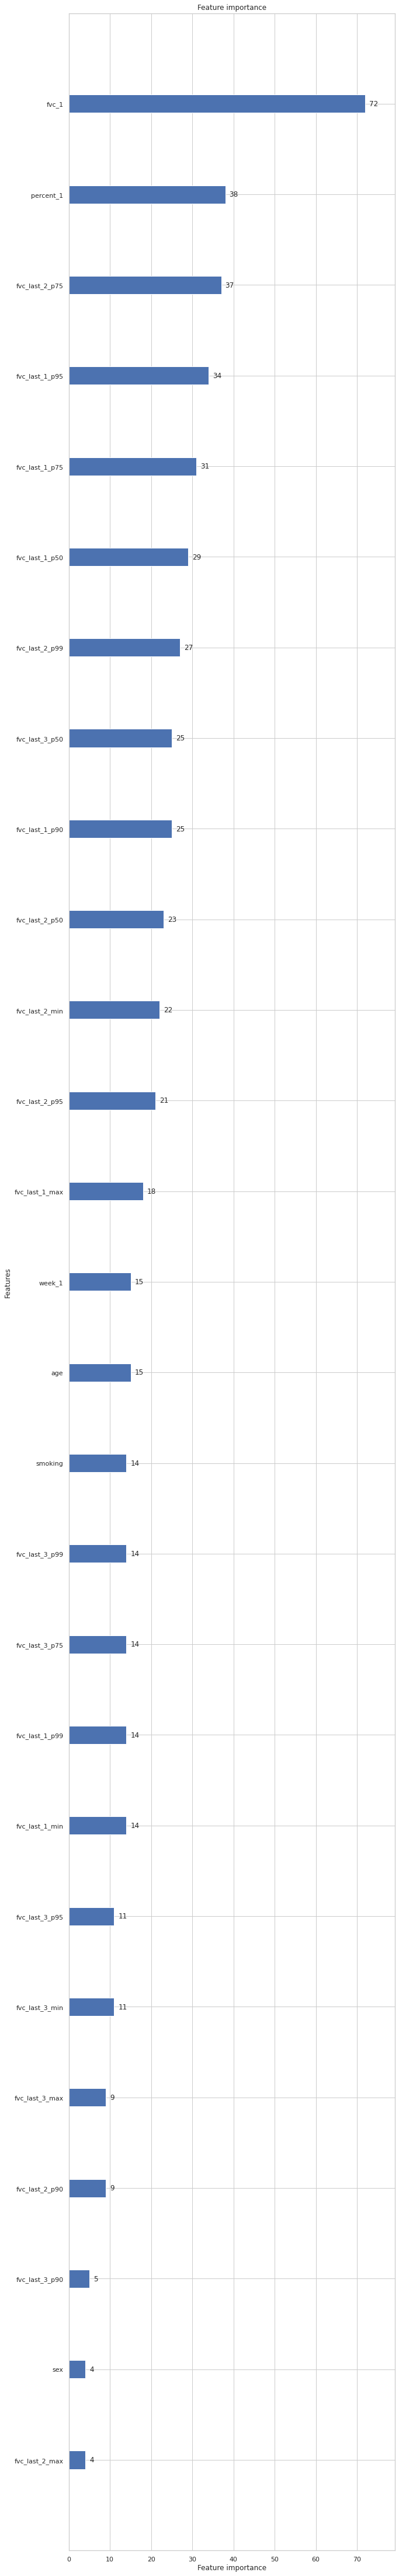

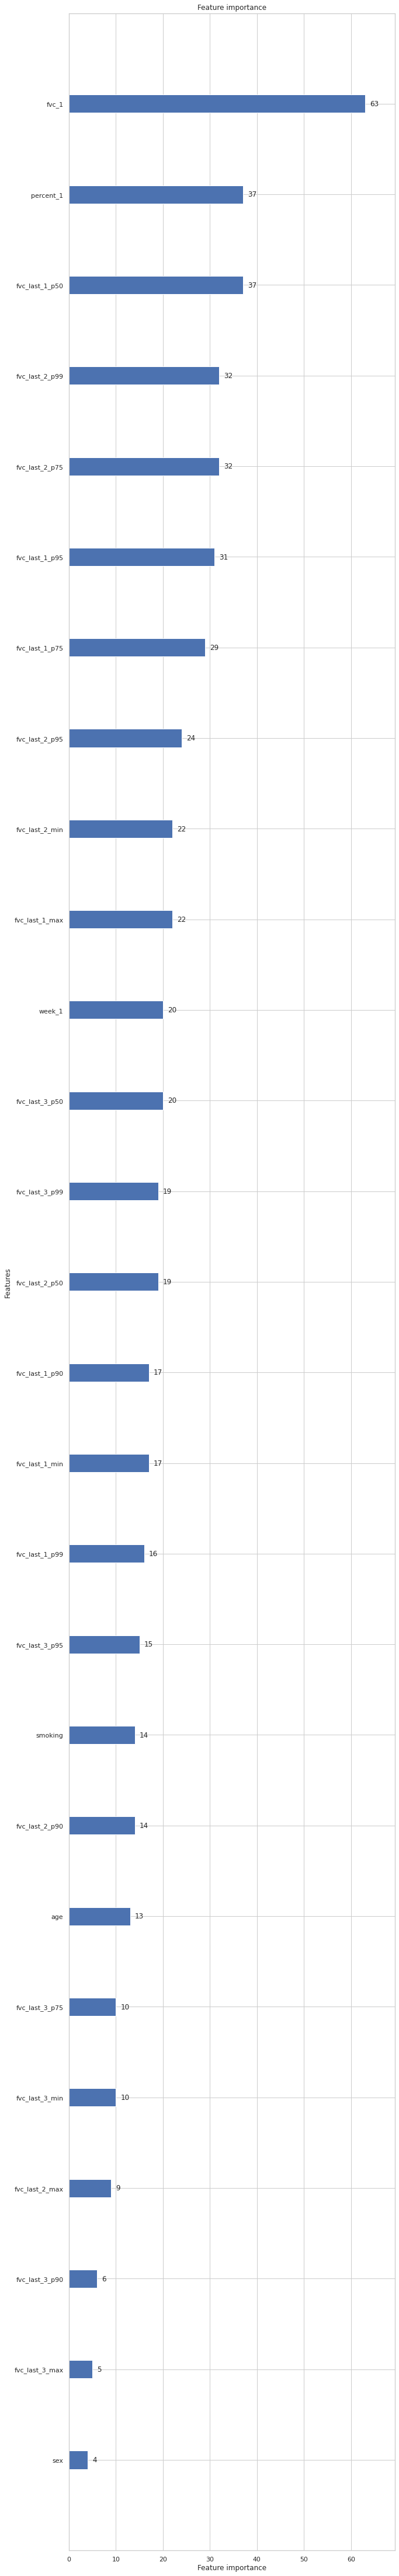

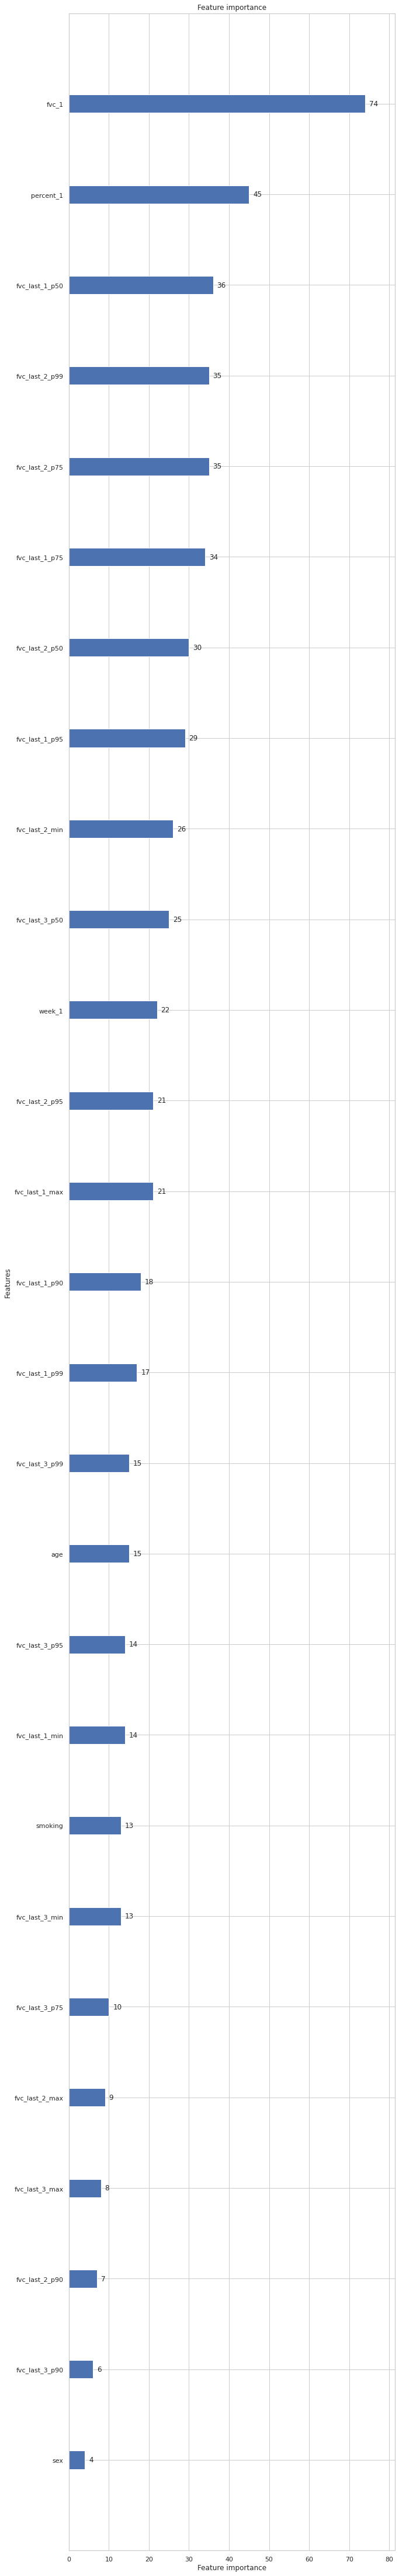

In [80]:
for lgbm in models:
    lgb.plot_importance(lgbm.best_estimator_['model'], figsize=(10, 80))

In [82]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')